In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 

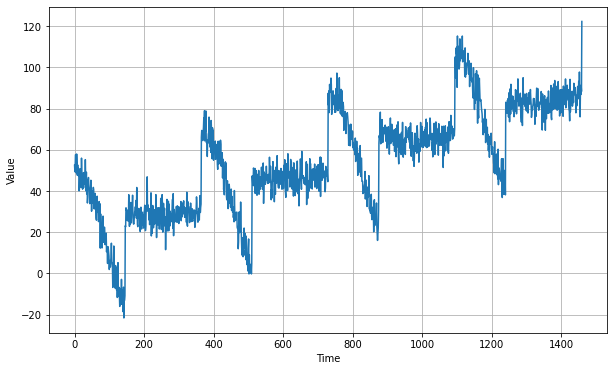

In [2]:
def plot_series(time,series,format='-',start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time,slope=0):
    return slope*time

def seasonal_pattern(season_time):
    # Just an arbitrary pattern,you can change it if you wish
    return np.where(season_time<0.4,
                    np.cos(season_time*2*np.pi),
                           1/np.exp(3*season_time))
                    
def seasonality(time,period,amplitude=1,phase=0):
    # Repeats the same pattern at each period
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)
                    
    
def noise(time,noies_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time=np.arange(4*365+1,dtype='float32')
baseline=10
series=trend(time,0.1)
amplitude=40
slope=0.05
noise_level=5

# Create the series
series=baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Update with noise
series+=noise(time,noise_level,seed=42)

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

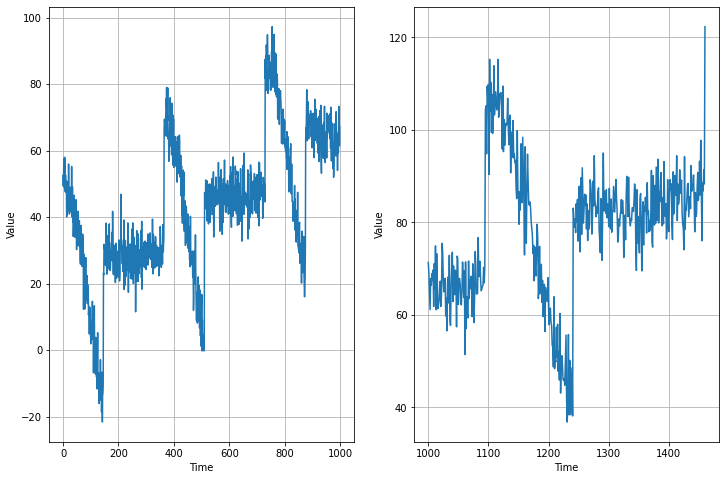

In [3]:
# Now that we have the time series,let's split it so we can start forecasting

split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]

time_valid=time[split_time:]
x_valid=series[split_time:]

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_series(time_train,x_train)

plt.subplot(1,2,2)
plot_series(time_valid,x_valid)

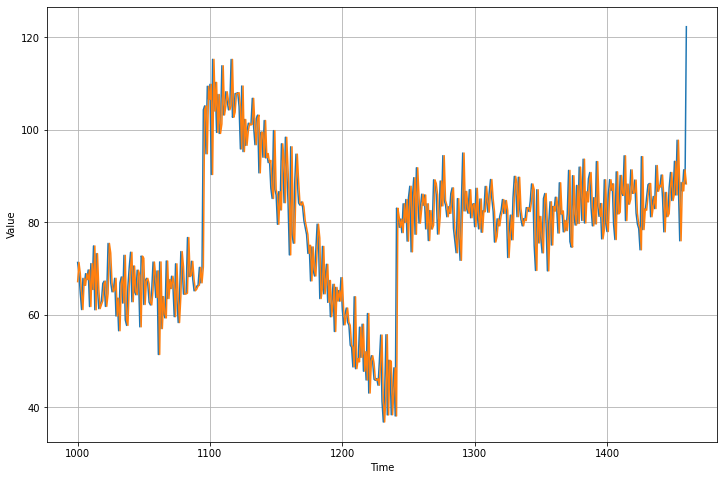

In [4]:
# Naive

naive_forecast=series[split_time-1:-1]
plt.figure(figsize=(12,8))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

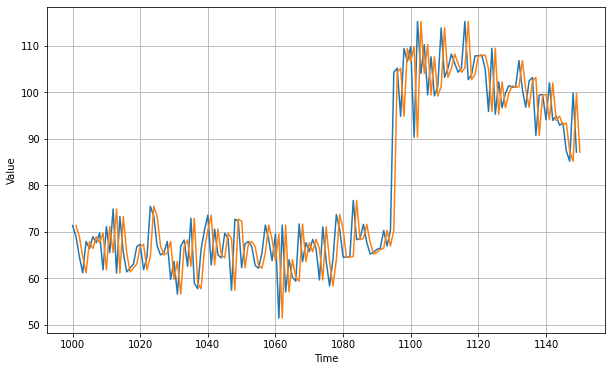

In [5]:
# Zoom in on the start of the validation period

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [6]:
print(keras.metrics.mean_squared_error(x_valid,naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy())


# That's our baseline

61.827534
5.937908


In [7]:
# Try moving average

def moving_average_forecast(series,window_size):
    # Forecast the mean of the last few values
    # If window_size=1 then this is quivalent to naive forecast
    
    forecast=[]
    for time in range(len(series)-window_size):
        forecast.append(series[time:time+window_size].mean())
        
    return np.array(forecast)

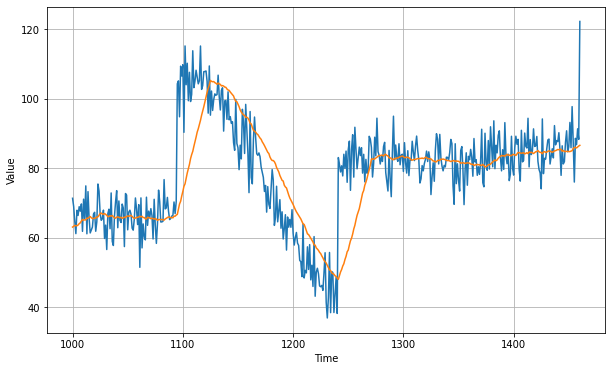

In [8]:
moving_avg=moving_average_forecast(series,30)[split_time-30:]

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,moving_avg)

In [9]:
print(keras.metrics.mean_squared_error(x_valid,moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy())


106.674576
7.142419


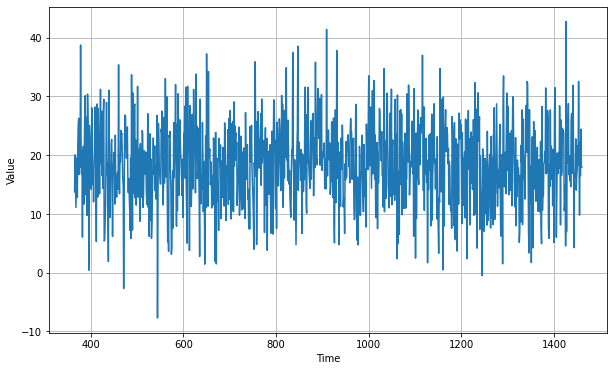

In [10]:
diff_series=(series[365:]-series[:-365])
diff_time=time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time,diff_series)

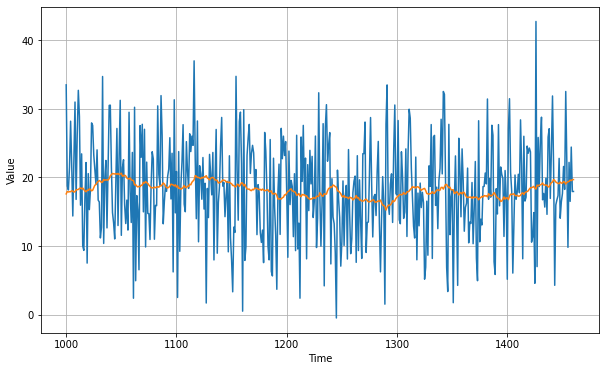

In [11]:
# Now the trend and seasonality seem to be gone
# so now we can use the moving average

diff_moving_avg=moving_average_forecast(diff_series,50)[split_time-365-50:]

plt.figure(figsize=(10,6))
plot_series(time_valid,diff_series[split_time-365:])
plot_series(time_valid,diff_moving_avg)

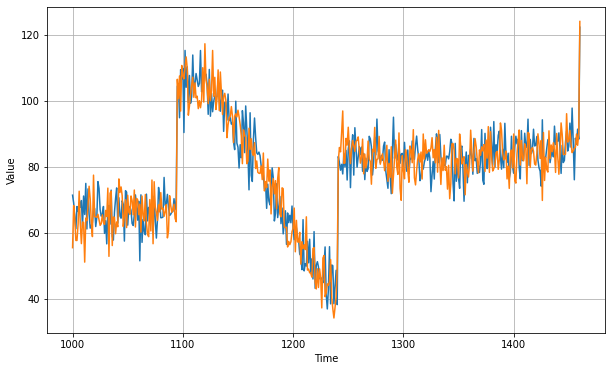

In [12]:
# Now let's bring back the trend and seasonality
# by adding the past value from t - 365

diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [13]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


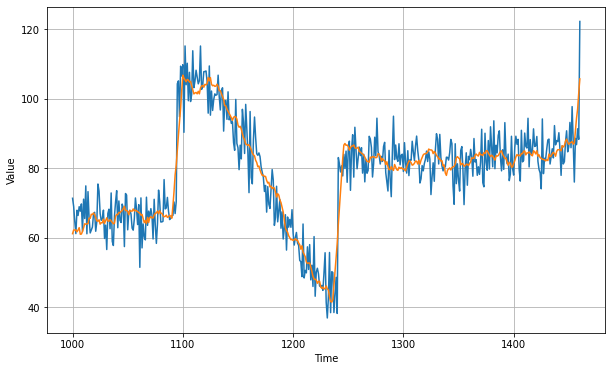

In [14]:
# However,the forecasts look a bit too random
# because we're just adding past values which is noisy
# Let's usa a moving averaging on past values to remove some of the noise

diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [15]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452263
4.569442
